In [29]:
import numpy as np
rnd_gen = np.random.default_rng(2024)
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

from online_cp.CPS import NearestNeighboursPredictionMachine

In [30]:
N = 300
X = rnd_gen.normal(loc=0, scale=1, size=(N, 4))
beta = np.array([2, 1, 0, 0])
Y = X @ beta + rnd_gen.normal(loc=0, scale=1, size=N)

Running online conformal prediction:   0%|          | 0/280 [00:00<?, ?it/s]

Error rate: 0.07857142857142857
Maximum martingale value: 1.4350454283039114


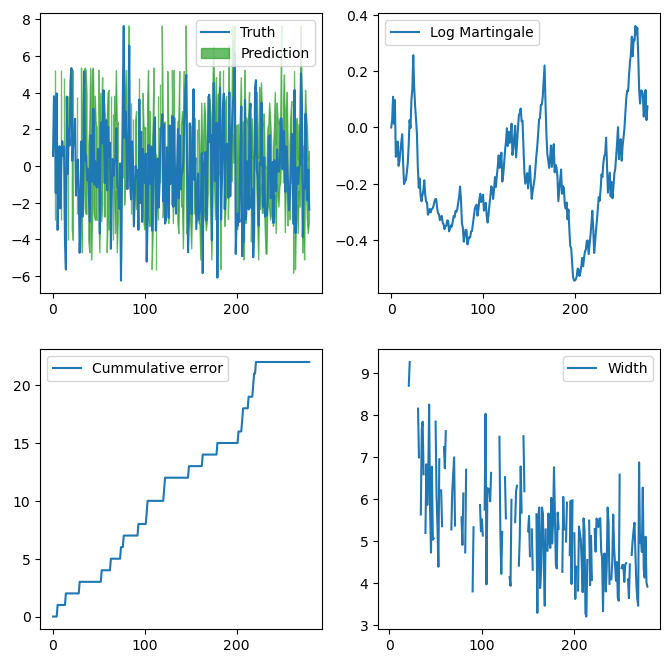

In [31]:
cps = NearestNeighboursPredictionMachine(k=19)

from online_cp.martingale import PluginMartingale

martingale = PluginMartingale(warning_level=100)

epsilon = 0.1

Err = 0 

cps.learn_initial_training_set(X[:int(np.ceil(2/epsilon))], Y[:int(np.ceil(2/epsilon))])

res = np.zeros(shape=(N-20, 8))

for i, (object, label) in tqdm(enumerate(zip(X[int(np.ceil(2/epsilon)):], Y[int(np.ceil(2/epsilon)):])), total=N-20, desc='Running online conformal prediction'):
    # Reality outputs object and a random number tau
    tau = rnd_gen.uniform(0, 1)

    # Forecaster outputs a conformal predictive distribution
    cpd, precomputed = cps.predict_cpd(x=object, return_update=True) # We return the precomputed update for later use
    
    # Which can be used to compute a prediction set
    Gamma = cpd.predict_set(tau=tau, epsilon=epsilon)

    # And perhaps the median is interesting too
    median = cpd.quantile(0.5, tau=tau)

    # Reality outputs label

    # Observe error
    err = cpd.err(Gamma=Gamma, y=label)
    Err += err

    # Learn new object
    cps.learn_one(x=object, y=label, precomputed=precomputed) # We pass precomputed as an argument to avoid redundant computations

    # Compute p-value
    p = cpd(y=label, tau=tau)

    # Update martingale
    martingale.update_log_martingale(p)

    res[i, 0] = Gamma[0]
    res[i, 1] = Gamma[1]
    res[i, 2] = label
    res[i, 3] = err
    res[i, 4] = Err
    res[i, 5] = cpd.width(Gamma)
    res[i, 6] = martingale.logM
    res[i, 7] = median

print(f'Error rate: {Err/(N-20)}')
print(f'Maximum martingale value: {martingale.max}')

fig, axs = plt.subplots(ncols=2, nrows=2, figsize=(8,8))
axs[0,0].plot(res[:, 2], label='Truth')
axs[0,0].fill_between(
    x=[i for i in range(N-20)],
    y1=res[:, 0],
    y2=res[:, 1],
    color='C2',
    alpha=0.7,
    label='Prediction'
)
axs[0,0].legend()

axs[0,1].plot(res[:,6], label='Log Martingale')
axs[0,1].legend()

axs[1,0].plot(res[:, 4], label='Cummulative error')
axs[1,0].legend()

axs[1,1].plot(res[:, 5], label='Width')
axs[1,1].legend()

In [32]:
# Just so that the notebook will fail if the martingale issues a warning
assert martingale.max <= 100

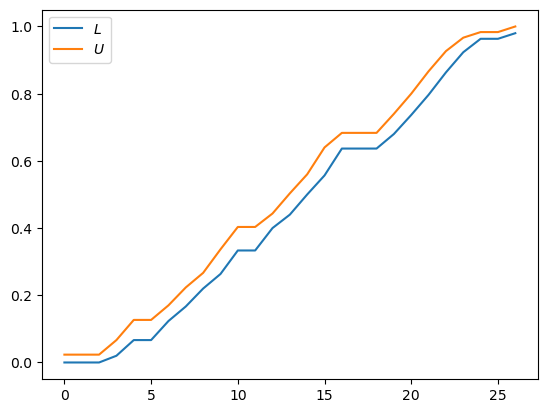

In [33]:
plt.plot(cpd.L, label=r'$L$')
plt.plot(cpd.U, label=r'$U$')
plt.legend()

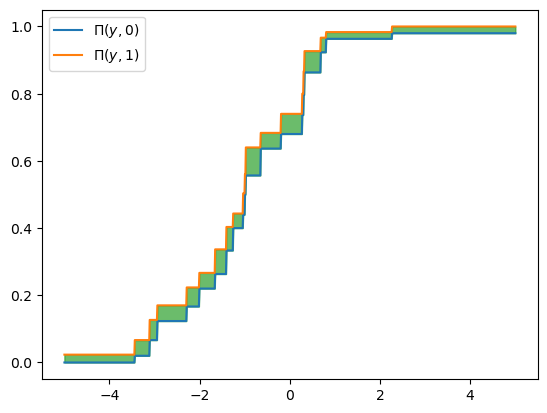

In [34]:
yrange = np.linspace(-5, 5, num=1000, endpoint=True)
plt.plot(
    yrange,
    [cpd(y=y, tau=0) for y in yrange],
    label=r'$\Pi(y, 0)$'
)
plt.plot(
    yrange,
    [cpd(y=y, tau=1) for y in yrange],
    label=r'$\Pi(y, 1)$'
)

plt.fill_between(
    yrange,
    [cpd(y=y, tau=0) for y in yrange],
    [cpd(y=y, tau=1) for y in yrange],
    alpha=0.7,
    color='C2'
)
plt.legend()